In [1]:
#!pip install jax
#!pip install -U "jax[cpu]"
#!pip install mat73
#!pip install scikit-learn-extra 
# Comment out the lines above after running them once. 


# Importing the libraries
import sys
import psutil
import time
import matplotlib.pyplot as plt

import numpy as np
import jax.numpy as jnp

from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import scipy
from scipy import signal
from scipy.signal import find_peaks

import mat73
import math
import os

# EMG Batch Decomposition - Calibration Algorithm

## Helper Functions

In [2]:
# This funtion extends the data. 
# It takes the data and appends a copy of it below. It does this according to the extension factor.
# Every new copy is padded by an additional 0. First copy 1 zero, second copy 2 zeroes, etc

def extend_array(array, ext_factor):
    # Get the shape of the array.    
    original_rows, original_columns = array.shape
    
    # Calculate the dimentions of the extended array
    new_rows = original_rows * ext_factor 
    new_columns = original_columns + (ext_factor - 1)

    # Initialize a new array filled with zeros
    ext_array = np.zeros((new_rows, new_columns), dtype=array.dtype)

    # Copy the original array into the new array at specific positions
    for i in range(ext_factor):
        ext_array[i*original_rows:(i+1)*original_rows, i:(i+original_columns)] = array # Is there a way to do this without loop? Would it be faster?
    
    return ext_array

In [3]:
# Notch filter to remove the grid 50Hz noise.
def notch_filter(array, notch_freq, sample_freq):
    # Create/view notch filter
    quality_factor = 30.0  # Quality factor
    b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, sample_freq)

    # apply notch filter to signal
    array_notched = signal.filtfilt(b_notch, a_notch, array)

    return array_notched

In [4]:
# Function that filters a specific frequency from the EMG signal. The EMG contains multiple channels that all nede to be filtered.
def filter_(emg, filter_freq, sample_freq):
    for i in range(emg.shape[0]):
        # Loop through the channels and filter away the 50hz with a notch filter.
        emg[i] = notch_filter(emg[i], filter_freq, sample_freq)
    return emg

In [5]:
def concatenate_matrices_horizontal(matrix1, matrix2):
    # Check if the matrices have the same number of rows
    if matrix1.shape[0] != matrix2.shape[0]:
        raise ValueError("Matrices must have the same number of rows for horizontal concatenation.")

    # Concatenate matrices horizontally
    concatenated_matrix = np.concatenate((matrix1, matrix2), axis=1)

    return concatenated_matrix

In [6]:
#randomized svd by scikitlearn, truncated svd by irlb, Lanczos method svd a.o.
#https://medium.com/@nestorarsenov/a-faster-svd-approximation-that-saves-time-and-makes-heavy-matrix-calculations-possible-310c48f5f9be

## User Variables

In [7]:
# Data file path
file_path = '../data/SIMULATION_56_40.mat'
#file_path2 = '../data/Dof2BRep.mat'

# Session Parameters
iteration_count = 50 #NITER in the matlab code
channel_count = 128 # Channel number
guess_count = 300 # Count of guesses in the activity matrix

# Plotting
plotting = True

## Algorithm Variables

In [8]:
# Variables that are given by the user.

# Compare with Matlab Niter = 50
# sillouhette threshold 0.9
# 5 sources found. Motor Unit Spike Train (Must)

# Algorithm Parameters
factor = 10; # Extention Factor = factor/number of channels. !!!! At the moment -> extention_factor = factor !!!!
outlier_noise_interval = 1e-3 # interval to remove identified time points (in s)
outlier_threshold = 99 # Outlier percentile

# Loop Parameters (Which loop? - Better name)
fixed_point_tolerance = np.exp(-4)
max_iteration = 50

# Peak finding Parameters
distance_threshold = 20  # Replace with your desired distance threshold
max_distance_ratio = 0.1  # Replace with your desired max distance ratio
silhouette_threshold = 0.8 # Treshold below the source is not considered
min_hz = 4 # Minimum spike train frequency for good source
max_hz = 35 # Maximum spike train frequency for good source

duplicate_threshold_value = 0.02 # Min distance between two spikes in seconds

## Data Fetching

The dimensions of the EMG data matrix are: (187, 122880)
The sample frequency is: 4096


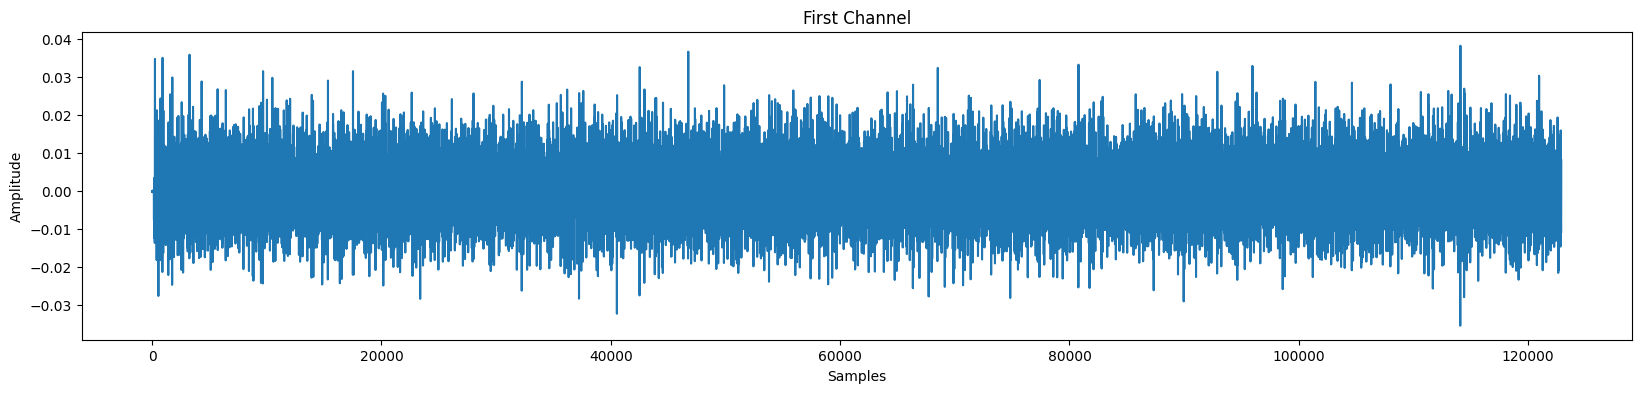

In [9]:
# Create a dictionary from the matlab data file.
data_dict = scipy.io.loadmat(file_path)
#data_dict = mat73.loadmat(file_path2) # Depending on the data this alternative method might be required.

# Extract the sample frequency
#sample_freq = data_dic['fsamp'][0][0]
sample_freq = 4096

# Extract the EMG data into a numpy array
emg = np.array(data_dict['EMGN_40'])#[0:channel_count])
#emg= concatenate_matrices_horizontal(data_dict['Dof2Rep']['bdataNeg'][0], data_dict['Dof2Rep']['bdataNeg'][1])
#emg = emg[0:channel_count]

# Delete the data_dict variable to free memory
del data_dict
# Extract the sample size and channel number
sample_shape = emg.shape

# Print Data Information
print(f'The dimensions of the EMG data matrix are: {sample_shape}')
print(f'The sample frequency is: {sample_freq}')

if plotting:
    plt.figure(figsize=(20,4))
    plt.plot(emg[0])
    plt.title("First Channel")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.show()

# Main Algorithm
This algorithm is based on the paper by Franscesco Negro (Multi-channel intramuscular and surface EMG decomposition by convolutive blind source separation. J Neural Eng. 2016)

It can be summarized to the following steps:
1. Extend the Data
2. Center by substracting the row-wise mean
3. Whiten the data with svd
4. Activity Extraction
5. Making initial Guesses

### Data Extension

The dimension of the extended EMG data matrix are: (1870, 122871)


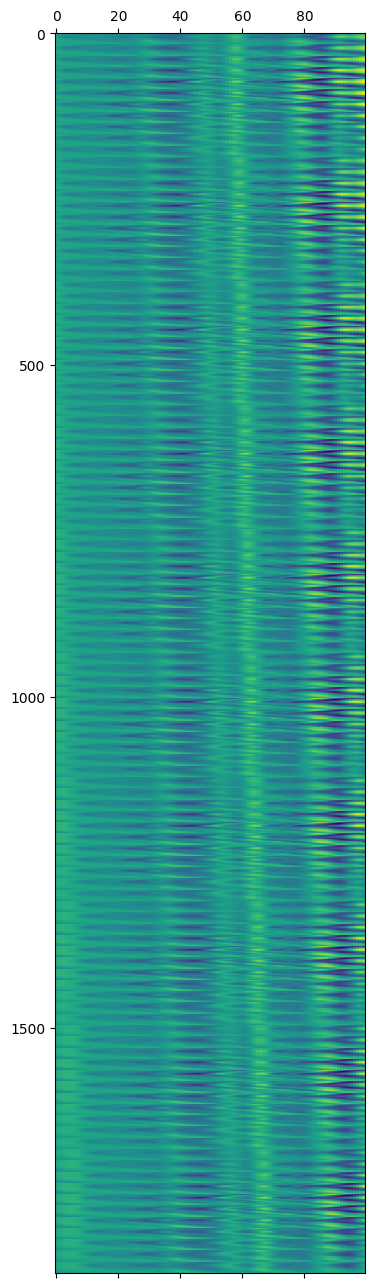

In [10]:
# calculate the extention factor
ext_factor = factor #round(factor/channel_count) #currently not used for faster iterations during developement. Needs to be changed!!

# extend the data
ext_emg = extend_array(emg, ext_factor)

# the Matrix should not contain any zeroes. Therefore the padded columns are removed
# Note that the index structure is inclusive of the first index value, but not the second index value. 
# So you provide a starting index value for the selection and an ending index value that is not included in the selection.
ext_emg = ext_emg[:, ext_factor-1:ext_emg.shape[1]-(ext_factor-1)]

# the mean is substracted to center the data row-wise before whitening
ext_emg = ext_emg - np.mean(ext_emg, axis=1, keepdims=True)

print(f'The dimension of the extended EMG data matrix are: {ext_emg.shape}')

if plotting:
    plt.matshow(ext_emg[:,300:400], fignum=100)
    plt.gca().set_aspect('auto')

### Withening

In [11]:

# Calculate the corrolation matrix to prevent doing the SVD on the full matrix. (Is that really what is appening?)
corr_ext_emg = np.matmul(ext_emg,  ext_emg.T) / ext_emg.shape[1] # What is this matrix really? Not quite sure I understand yet.

# Compute the SVD
U, S, V = np.linalg.svd(corr_ext_emg)   # SVD correlation matrix

anti_zero = np.percentile(S, 25) # Take the lowest 20th percentile treshold as a value to prevent division by 0. (the percentile is taken as the scale of the data is not known)
# Inverse eigenvalues. Not sure why we do this
SI = 1 / (np.sqrt(S  + anti_zero))  

# Calculate the whitening matrix
wht_mat = (U @ np.diag(SI)) @ V # Remember that in python the SVD functio returns the transposed V. So the funciton is slightly different than in Matlab         

# Whiten the extended emg data matrix.
wht_emg = wht_mat @ ext_emg

<Figure size 640x480 with 0 Axes>

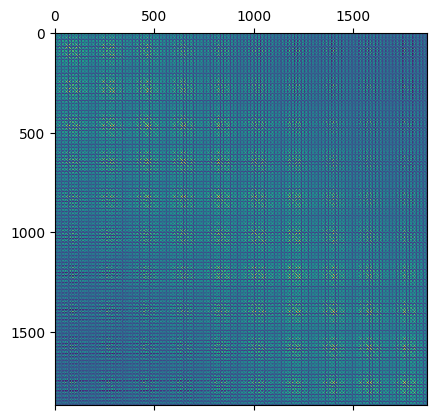

<Figure size 640x480 with 0 Axes>

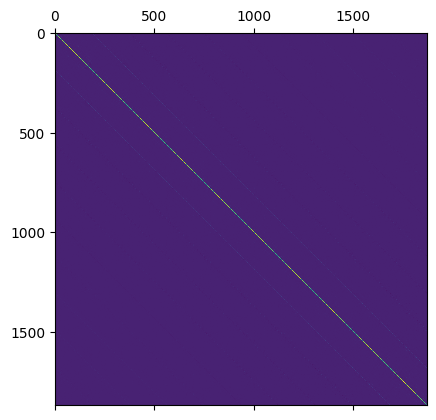

In [12]:
if plotting:
    # Check the whiteneing by comparing plots before and after. Multiplying them with itself gives a better visual representation.
    plt.figure(1)
    plt.matshow(ext_emg @ ext_emg.T, fignum=100)
    plt.gca().set_aspect('auto')
    plt.show()

    plt.figure(2)
    plt.matshow(wht_emg @ wht_emg.T, fignum=100)
    plt.gca().set_aspect('auto')
    plt.show()

### Activity Calculation

In [13]:
# Activty Matrix / act_m
activity_mx = np.sum(np.abs(wht_emg) ** 2, axis=0) #First the absolute values squared, then the sum of rows

In [14]:
# Remove the begining and end of the samples. A spike can't occure before or after the time of a full spike.
activity_mx[0:int(outlier_noise_interval*sample_freq)+1] = 0
activity_mx[-int(outlier_noise_interval*sample_freq)-1:] = 0
activity_length = activity_mx.shape
print(activity_mx.shape)

# Remove outliers - Probably not a good idea. rather reduce noise on individual channels
activity_outlier_treshold = np.percentile(activity_mx, outlier_threshold)    # remove some artifacts from the activity index
index = np.where(activity_mx > activity_outlier_treshold)[0]                     # find indices where ACT > TH_ACT

# Remove a band around the outliers. The outliers are possibly do to effect that lasts over time. Needs to be checked with real data. For the moment we'll use this method. Need to check with filtereing the outliers before the activity matrix and after. Not convinced that doing it after makes much sense. The spikes are so fast that the would still represent a real spike. Might just make the initial guess biased but not necessarly the spikes themselves.
noindex = []
for i in range(len(index)):
    activity_mx[int(index[i]-np.round(outlier_noise_interval*sample_freq)):int(index[i]+np.round(outlier_noise_interval*sample_freq))] = 0

(122871,)


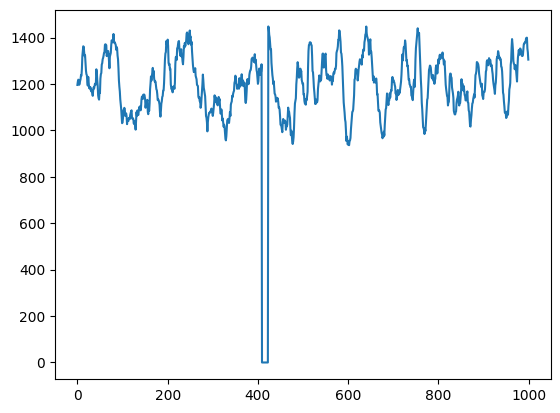

In [15]:
if plotting:
    plt.figure(4)
    plt.plot(activity_mx[1000:2000])
    plt.show()

### Find Initial Points

# This might need to be integreated to the main loop. If a source is strong all the initial guesses will be from that source. Which leads to unecessary calculations. Might be smarter to calculate one source and then remove all the spikes attributed to that source.
# Find the indeces of the maximum activity
guess_indices = []

# Loop to get the desired count of guesses
for i in range(guess_count):
    max_activity_index = np.argmax(activity_mx)# Find maximum
    guess_indices.append(max_activity_index) # Append the result
    
    # remove the point and the surrounding points from the activity matrix
    activity_mx[int(max_activity_index-np.round(outlier_noise_interval * sample_freq)):int(max_activity_index+np.round(outlier_noise_interval * sample_freq))] = 0

print(guess_indices)
print(len(guess_indices))

# Initialize guess_indices
guess_indices = []

# Define variables for segment count and guess count per segment
segment_count = 30
guess_count_per_segment = 10

# Calculate segment size
segment_size = len(activity_mx) // segment_count

# Outer loop to iterate over segments
for segment_index in range(segment_count):
    segment_start = segment_index * segment_size
    segment_end = min((segment_index + 1) * segment_size, len(activity_mx))
    
    # Get the segment of activity_mx
    segment_activity_mx = np.array(activity_mx[segment_start:segment_end])
 
    # Inner loop to get the desired count of guesses for each segment
    for i in range(guess_count_per_segment):
        max_activity_index = np.argmax(segment_activity_mx)# Find maximum
        guess_indices.append(max_activity_index) # Append the result
        
        # remove the point and the surrounding points from the activity matrix
        segment_activity_mx[int(max_activity_index-np.round(outlier_noise_interval * sample_freq)):int(max_activity_index+np.round(outlier_noise_interval * sample_freq))] = 0

print("Guess indices:", guess_indices)
print(len(guess_indices))

## Functions of Main Loop 
The code below (with the initial point finding above) is running on the main loop in the matlab code. The goal is the seperate it into processes.

I will make functions fo all the different steps. This will allow me to easily test the different options to parallelize the loop. 

### Slicing the Whitened and Extended EMG Matrix
The Matrix is sliced to return the column corresponding to the guessed activity index

In [16]:
# Doesn't need to be in the loop
def fetch_and_normalize_matrix_columns(matrix, column_indices, show_plot):
    # Extract the column
    columns = matrix[:,column_indices] 
    # Normalizing the vector
    normalized_columns = columns/np.linalg.norm(columns, axis=0)
    
    # Plot the result
    if show_plot:
        plt.figure(5)
        plt.plot(normalized_columns[0])
        plt.show()
        
    return normalized_columns

### Fixed Point Algorithm
This step is done to improve the peaks. Still not quite sure what it does.

In [17]:
def apply_fixed_point_algorithm(fixed_point_tolerance, max_iteration, matrix, array, show_plot):
    G = lambda x: 1/2 * x**2 # Maybe more descriptive name would be better
    DG = lambda x: x
    
    # Matrix dimensions
    mx_dimension_n = matrix.shape[0] 
    mx_dimension_m = matrix.shape[1]
    
    # Projecting Vectors matrix
    pv_mx = np.zeros((mx_dimension_n, max_iteration))

    # Initialize the projection vector randomly
    initial_projection_vector = np.random.randn(mx_dimension_n, 1)
    initial_projection_vector = initial_projection_vector / np.linalg.norm(initial_projection_vector)
    
    iteration_counter = 0 
    # Convergence condition: stop when the dot product of the current projection vector and matrix is close to 1
    while abs(abs(np.dot(initial_projection_vector.T, array)) - 1) > fixed_point_tolerance and iteration_counter < max_iteration:
        initial_projection_vector = array  # Update the projection vector for stopping at fixed_point_tolerance

        # Calculate the estimation source
        intermediate_result = np.dot(array.T, matrix)  

        # Update the projection vector using the fixed-point iteration
        updated_projection_vector = np.dot(matrix, G(intermediate_result).T) / mx_dimension_m - np.sum(DG(intermediate_result)) * array / mx_dimension_m  
        #updated_projection_vector = updated_projection_vector/np.linalg.norm(updated_projection_vector)  # Normalize the updated projection vector

        # Deflation (decorrelation)
        array = updated_projection_vector - np.dot(pv_mx, np.dot(pv_mx.T, updated_projection_vector))  
        array = array / np.linalg.norm(array)  # Normalize the array
        #print(abs(abs(np.dot(initial_projection_vector.T, array)) - 1))

        iteration_counter += 1  # Increment the loop counter
    
    #print(iteration_counter)
    final_projection_vector = updated_projection_vector.real   # Save the latest projecting vector
    pv_mx[:, 1] = final_projection_vector  # For deflation 1 represents the iteration count of the entire loop!!!

    if show_plot:
        plt.figure(6)
        plt.plot(final_projection_vector)
        plt.show()
    
    return pv_mx, final_projection_vector

### Extract the Source

In [18]:
def estimate_source(projection_vector, matrix, show_plot):
    source = projection_vector.dot(matrix)
    
    if show_plot:
        plt.figure(7)
        plt.plot(source[0:1000])
        plt.show()
    
    return source

In [19]:
def remove_outliers(data, keep_percentage=100):
    """
    Remove outliers from a list based on the modified percentile values.

    Parameters:
    - data: List of numeric values
    - keep_percentage: Percentage of samples to keep (default is 100%)

    Returns:
    - filtered_data: List with outliers removed
    - removed_indices: Indices of the removed samples
    """
    # Enumerate the data to keep track of indices
    enumerated_data = list(enumerate(data))

    # Sort the data based on values
    sorted_data = sorted(enumerated_data, key=lambda x: x[1])

    # Calculate the lower and upper percentile values based on keep_percentage
    lower_percentile = (100 - keep_percentage) / 2
    upper_percentile = 100 - lower_percentile

    # Calculate the lower and upper bounds based on the modified percentiles
    lower_bound = np.percentile([value[1] for value in sorted_data], lower_percentile)
    upper_bound = np.percentile([value[1] for value in sorted_data], upper_percentile)

    # Keep only the data points within the specified percentile range
    filtered_data = [value[1] for value in sorted_data if lower_bound <= value[1] <= upper_bound]

    # Get the indices of removed samples
    removed_indices = [value[0] for value in enumerated_data if value[1] < lower_bound or value[1] > upper_bound]

    return filtered_data, removed_indices

In [20]:
def remove_samples_by_indices(data, indices):
    """
    Remove samples from a list based on given indices.

    Parameters:
    - data: List of values
    - indices: List of indices to remove

    Returns:
    - List with corresponding samples removed
    """
    return [value for i, value in enumerate(data) if i not in indices]

### Find the Peaks

In [21]:
def classify_discharges(signal, sample_frequency, distance_threshold, max_distance_ratio, show_plot):
    # Compute TVI (Total Variance Index)
    total_variance_index = np.abs(signal ** 2)

    # Normalize TVI
    normalization_factor = np.linalg.norm(total_variance_index)
    normalized_tvi = total_variance_index / normalization_factor

    # Find peaks in the normalized TVI
    peak_indices, _ = find_peaks(normalized_tvi, distance=distance_threshold)

    # Extract peaks from TVI
    peaks = normalized_tvi[peak_indices]
    
    
    
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10)
    # Testing if the initalisation is the problem
    kmeans = KMeans(n_clusters=2, init='random', random_state=42, n_init=10)
    #plt.plot(peaks, label='Original Signal')
    kmeans.fit(peaks.reshape(-1, 1))
    # Get cluster labels and centers
    cluster_labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_

    
    # Calculate mean cluster centeroids - This is absolutely not necessary as the cluster centers are equivalent to the means
    mean_centeroid_1 = np.mean(normalized_tvi[peak_indices[cluster_labels == 0]])
    mean_centeroid_2 = np.mean(normalized_tvi[peak_indices[cluster_labels == 1]])

    # Determine maximum and minimum centeroids
    maximum_centeroid, cluster_index = np.max([mean_centeroid_1, mean_centeroid_2]), np.argmax([mean_centeroid_1, mean_centeroid_2])

    similarity_coefficient = maximum_centeroid
    non_similarity_coefficient = np.min([mean_centeroid_1, mean_centeroid_2])

    # Find indices of the selected cluster
    indices_in_selected_cluster = np.where(cluster_labels == cluster_index)[0]

    # Calculate Silhouette Score
    silhouette = silhouette_score(peaks.reshape(-1, 1), cluster_labels, metric='euclidean')

    # Calculate Coefficient of Variation for Inter-Spike Intervals
    interval_indices = peak_indices[indices_in_selected_cluster]

    inter_spike_intervals = np.diff(interval_indices / sample_frequency)
    

    coefficient_of_variation = np.std(inter_spike_intervals) / np.mean(inter_spike_intervals) * 100
    
    if False:
        # Plotting for visualization (you can customize this based on your needs)
        plt.figure(figsize=(12, 6))

        # Plot the original signal
        plt.subplot(2, 1, 1)
        plt.plot(signal, label='Original Signal')
        plt.title('Original Signal')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()


        interval_indices = interval_indices[interval_indices<4096]
        peaks = peaks[interval_indices]
        # Plot the TVI and identified peaks
        plt.subplot(2, 1, 2)
        plt.plot( normalized_tvi[0:4096], label='Total Variance Index')
        plt.plot(interval_indices, peaks, 'ro', label='Peaks')
        plt.title('Total Variance Index with Identified Peaks')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()

        plt.tight_layout()
        plt.show()
        

    
    return normalized_tvi, normalization_factor, peaks, peak_indices, indices_in_selected_cluster, interval_indices, silhouette, coefficient_of_variation, cluster_centers, similarity_coefficient, non_similarity_coefficient


# Remove Erronous Sources and Duplicate Peaks

In [22]:
def indices_below_threshold(lst, threshold):
    """
    Returns the indices of elements in the list that are lower than the threshold.

    Parameters:
    - lst (list): The input list.
    - threshold: The threshold value.

    Returns:
    - List of indices.
    """
    return [index for index, value in enumerate(lst) if value < threshold]


In [23]:
def remove_duplicate_peaks(timestamps, threshold):
    """
    Removes peaks from the list if the time difference between adjacent peaks
    is below the specified threshold.

    Parameters:
    - timestamps (list): List of chronological timestamps.
    - threshold (int): Threshold time.

    Returns:
    - List of timestamps after removing events below the threshold.
    """
    i = 0
    while i < len(timestamps) - 1:
        time_difference = timestamps[i + 1] - timestamps[i]

        if time_difference < threshold:
            # Remove the second timestamp (timestamps[i+1])
            timestamps = np.delete(timestamps,(i + 1))
        else:
            # Move to the next index only if the timestamps were not removed
            i += 1

    return timestamps

# Start Loop

In [24]:
show_plot = False
print(len(guess_indices))
sliced_wht_emg = fetch_and_normalize_matrix_columns(wht_emg, guess_indices, show_plot)

NameError: name 'guess_indices' is not defined

In [ ]:
# Looping through the indices here
def sequential_loop(fixed_point_tolerance, max_iteration, wht_emg, sliced_wht_emg, show_plot, sample_freq, distance_threshold, max_distance_ratio):

    # Explanation needed
    pv_mx, final_projection_vector = apply_fixed_point_algorithm(fixed_point_tolerance, max_iteration, wht_emg, sliced_wht_emg, show_plot)

    # Explanation needed
    source = estimate_source(final_projection_vector, wht_emg, show_plot)
    
    # Explanation needed
    tvi, normalization_factor, peaks, peak_indices, selected_indices, interval_indices, silhouette, coefficient_of_variation, cluster_centers, similarity_coefficient, non_similarity_coefficient = classify_discharges(source, sample_freq, distance_threshold, max_distance_ratio, show_plot)
    # Explanation needed
    interval_indices = remove_duplicate_peaks(interval_indices, duplicate_threshold_value*sample_freq)

    return tvi, normalization_factor, peaks, peak_indices, selected_indices, interval_indices, silhouette, coefficient_of_variation, cluster_centers, similarity_coefficient, non_similarity_coefficient


In [ ]:
def fXcorr(Ind1, Ind2, Lim: int):
    # Cross-correlation function
    xcor = np.zeros(2 * Lim + 1)
    for k in range(-Lim, Lim + 1):
        xcor[k + Lim] = len(set(Ind1).intersection(set(np.array(Ind2) + k)))
    return xcor

#np.seterr(all='raise')
# Looping through the indices here
start = time.time()
show_plot = False
interval_indices_mx = []
silhouette_mx = []
coefficient_of_variation_mx = []
recording_time = activity_length[0]/sample_freq
tvi_mx = []
norm_factor_mx = []
cluster_centers_mx = []


for i in range(len(sliced_wht_emg[0])):
    print("\r", end=" ")
    print(f'Source {i} is being processed.', end='\r')
    tvi, normalization_factor, peaks, peak_indices, selected_indices, interval_indices, silhouette, coefficient_of_variation, cluster_centers, similarity_coefficient, non_similarity_coefficient =  sequential_loop(fixed_point_tolerance, max_iteration, wht_emg, sliced_wht_emg[:,i], show_plot, sample_freq, distance_threshold, max_distance_ratio)
    # Check if the source is good
    print(recording_time*min_hz, len(interval_indices), recording_time*max_hz)
    if silhouette >= silhouette_threshold: # Check if the silhouette score is high enough
        if (recording_time*min_hz)<len(interval_indices)<(recording_time*max_hz): # Check if htere are enough spikes in the train spike
            
            interval_indices_mx.append(interval_indices)
            silhouette_mx.append(silhouette)
            coefficient_of_variation_mx.append(coefficient_of_variation)
            tvi_mx.append(tvi)
            norm_factor_mx.append(normalization_factor)
            cluster_centers_mx.append(cluster_centers)
        else:
            print(f'Source {i} has a too low or too high spike frequency.')

    else:
        print(f'Silhouette score of source {i} is too low.')
end = time.time()

print('\n')
print(end-start)
print(f'{len(interval_indices_mx)} sources found')

In [ ]:
#np.seterr(all='raise')
# Looping through the indices here
start = time.time()
show_plot = False
interval_indices_mx = []
silhouette_mx = []
coefficient_of_variation_mx = []
recording_time = activity_length[0]/sample_freq
tvi_mx = []
norm_factor_mx = []
cluster_centers_mx = []
loop_activity_mx = activity_mx
guess_index_stopper = 0

for i in range(100):
    max_activity_index = [np.argmax(loop_activity_mx)]# Find maximum
    if max_activity_index == guess_index_stopper:
        print(max_activity_index)
        print(guess_index_stopper)
        break
    guess_index_stopper = max_activity_index

    print(max_activity_index)
    print(len(loop_activity_mx[loop_activity_mx>0]))

    sliced_wht_emg = fetch_and_normalize_matrix_columns(wht_emg, max_activity_index, show_plot)


    print("\r", end=" ")
    print(f'Source {i} is being processed.', end='\r')
    tvi, normalization_factor, peaks, peak_indices, selected_indices, interval_indices, silhouette, coefficient_of_variation, cluster_centers, similarity_coefficient, non_similarity_coefficient =  sequential_loop(fixed_point_tolerance, max_iteration, wht_emg, sliced_wht_emg[:,0], show_plot, sample_freq, distance_threshold, max_distance_ratio)
   
    
    # Check if the source is good
    if silhouette >= silhouette_threshold: # Check if the silhouette score is high enough
        if (recording_time*min_hz)<len(interval_indices)<(recording_time*max_hz): # Check if htere are enough spikes in the train spike
            print(len(interval_indices))
            interval_indices_mx.append(interval_indices)
            silhouette_mx.append(silhouette)
            coefficient_of_variation_mx.append(coefficient_of_variation)
            tvi_mx.append(tvi)
            norm_factor_mx.append(normalization_factor)
            cluster_centers_mx.append(cluster_centers)

            # remove the point and the surrounding points from the activity matrix
            # Do it according to the source in question
            for index in  interval_indices:   
                loop_activity_mx[int(index-np.round(outlier_noise_interval * sample_freq)):int(index+np.round(outlier_noise_interval * sample_freq))] = 0
        else:
            print(f'Source {i} has a too low or too high spike frequency.')
            loop_activity_mx[int(max_activity_index-np.round(outlier_noise_interval * sample_freq)):int(max_activity_index+np.round(outlier_noise_interval * sample_freq))] = 0

    else:
        print(f'Silhouette score of source {i} is too low.')
        loop_activity_mx[int(max_activity_index-np.round(outlier_noise_interval * sample_freq)):int(max_activity_index+np.round(outlier_noise_interval * sample_freq))] = 0
    
   

end = time.time()

print('\n')
print(end-start)
print(f'{len(interval_indices_mx)} sources found')

[62659]
114526
Source sliced dotg processed.
0.48008310548180394
763
[22527]
86822
Source sliced dotg processed.
0.6615227001916638
739
[80781]
66751
Source sliced dotg processed.
0.7099273151790709
718
[94669]
52967
Source sliced dotg processed.
0.619201217052644
719
[93539]
41265
Source sliced dotg processed.
0.5465216333779817
718
[81760]
32765
Source sliced dotg processed.
0.4647653382582091
742
[14068]
25325
Source sliced dotg processed.
0.5856719397916645
687
[92663]
19905
Source sliced dotg processed.
0.5982320690317864
735
[55624]
15142
Source sliced dotg processed.
0.44664438394319433
717
[65939]
11683
Source sliced dotg processed.
0.721361361330215
713
[8299]
8831
Source sliced dotng processed.
0.5344953047778735
740
[25938]
7586
Source sliced dotng processed.
0.4963747271692723
713
[3787]
5881
Source sliced dotng processed.
0.6378524278009515
741
[45664]
4698
Source sliced dotng processed.
0.4243565615560198
707
[58721]
3619
Source sliced dotng processed.
0.4277284149381877


/tmp/ipykernel_95084/613346518.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loop_activity_mx[int(max_activity_index-np.round(outlier_noise_interval * sample_freq)):int(max_activity_index+np.round(outlier_noise_interval * sample_freq))] = 0


Source sliced dot
0.4572170758594706
763
[105543]
1420
Source sliced dotng processed.
0.345177711330963
734
[7515]
1122
Source sliced dotng processed.
0.4294116612055499
736
[80108]
870
Source sliced dotng processed.
0.28109766109395323
723
[74588]
765
Source sliced dotng processed.
0.331417386131398
707
[41313]
650
Source sliced dotng processed.
0.3654193510833816
721
[9167]
557
Source sliced dotng processed.
0.38368954647171444
728
[91778]
479
Source sliced dotng processed.
0.34289036367227893
692
[120532]
429
Source sliced dotng processed.
0.492588176796486
719
[31239]
361
Source sliced dotng processed.
0.34055110187311244
745
[47463]
316
Source sliced dotng processed.
0.21415549743128648
716
[81251]
248
Source sliced dotng processed.
0.22562695784272815
Silhouette score of source 29 is too low.
[59709]
246


/tmp/ipykernel_95084/613346518.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loop_activity_mx[int(max_activity_index-np.round(outlier_noise_interval * sample_freq)):int(max_activity_index+np.round(outlier_noise_interval * sample_freq))] = 0


Source sliced dot
0.4223735769275705
727
[112952]
205
Source sliced dotng processed.
0.2993943026621898
749
[31408]
185
Source sliced dotng processed.
0.2519311644753745
756
[50070]
173
Source sliced dotng processed.
0.21537586578215373
725
[113247]
168
Source sliced dotng processed.
0.2822046757791953
722
[41480]
158
Source sliced dotng processed.
0.28809340985672127
741
[299]
155
Source sliced dotng processed.
0.2794569001097562
743
[115730]
134
Source sliced dotng processed.
0.24547865151467138
732
[27]
126
Source sliced dotng processed.
0.05077597464093334
735
[27]
[27]


81.36951208114624
37 sources found


In [ ]:
a = np.array([0,1,2,3,4])
b = np.array([1,2,3,4,5][])

print(a.dot(b))

In [ ]:
unit_count = len(interval_indices_mx)
LW1 = 50e-3
LW2 = 0.5e-3
independent_unit_idx = []
duplicate_unit_idx = []
BUONA = []
tvi_good = []
silhouette_good = []
cluster_good = []
norm_fact_good = []

for unit_idx_a in range(unit_count):
    
    duplicate_unit_cov = [] # Initiate the array
    # Calculate the COV in Python
    duplicate_unit_cov.append([unit_idx_a, coefficient_of_variation_mx[unit_idx_a]])
  
    if unit_idx_a not in duplicate_unit_idx: # Check if the unit a is a duplicate
        
        
        for unit_idx_b in range(unit_idx_a, unit_count): 
            print(unit_idx_a, unit_idx_b)
            if unit_idx_b not in duplicate_unit_idx: # Check if the unit b is a duplicate
            
                
                corr = fXcorr(interval_indices_mx[unit_idx_a], interval_indices_mx[unit_idx_b], int(np.round(LW1*sample_freq)))
                corr_max_idx = np.argmax(corr)
                corr_max = corr[corr_max_idx]

                if corr_max_idx > np.round(LW2*sample_freq)+1 and corr_max_idx< len(corr)-np.round(LW2*sample_freq):
                        SENS = np.sum(corr[int(corr_max_idx-np.round(LW2*sample_freq)):int(corr_max_idx+np.round(LW2*sample_freq))])#/np.max([len(interval_indices_mx[unit_idx_a]),len(interval_indices_mx{unit_idx_b})])*100
                        
                        if SENS>30: 
                            duplicate_unit_idx.append(unit_idx_b) 
                            duplicate_unit_cov.append([unit_idx_b, coefficient_of_variation_mx[unit_idx_b]])

        index = np.argmin([item[1] for item in duplicate_unit_cov])
 
        independent_unit_idx.append(duplicate_unit_cov[index][0])
        BUONA.append(interval_indices_mx[duplicate_unit_cov[index][0]])  
        tvi_good.append(tvi_mx[duplicate_unit_cov[index][0]])  
        silhouette_good.append(silhouette_mx[duplicate_unit_cov[index][0]])  
        cluster_good.append(cluster_centers_mx[duplicate_unit_cov[index][0]])  
        norm_fact_good.append(norm_factor_mx[duplicate_unit_cov[index][0]])  
 

print(unit_count)
print('Result')
print(independent_unit_idx)
print("Duplicate Num:")
print(len(duplicate_unit_idx))
print(BUONA)
print(len(BUONA))


0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
2 36
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27
3 28
3 29
3 30
3 31
3 32
3 33
3 34
3 35
3 36
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
6 16
6 17
6 18
6 19
6 20
6 21
6 22
6 23
6 24
6 25
6 26
6 27
6 28
6 29
6 30
6 31
6 32
6 33
6 34
6 35
6 36
7 7
7 8
7 9
7 10
7 11
7 12
7 13
7 14
7 15
7 16
7 17
7 18
7 19
7 20
7 21
7 22
7 23
7 24
7 25
7 26
7 27
7 28
7 29
7 30
7 31
7 32
7 33
7 34
7 35
7 36
8 8
8 9
8 10
8 11
8 12
8 1

In [ ]:
if not(show_plot):
      plt.figure(8)
      plt.plot(tvi_mx[40])
      plt.show()

In [ ]:

for tvi_values in tvi_good:
    plt.figure(10)
    plt.plot(tvi_values[0:1000])
    plt.title(f"TVI_MX: {tvi_values[0]}")  # You can customize the title based on your needs
    plt.show()

In [ ]:
for spikes_train in BUONA:
    plt.figure(figsize=(40, 4))
    time_interval_indices = spikes_train / sample_freq
    plt.vlines(time_interval_indices, 0,1, color='black', linestyle='solid', label='Spikes')
    # Customize the plot as needed
    plt.xlabel('Time in S')
    plt.title('Spike Train')
    plt.legend()
    plt.show()

In [ ]:
import json

# Sample arrays
array1 = [1, 2, 3,5]
array2 = ['a', 'b', 'c',6]
array3 = [True, False, True,5]


# Zip the arrays together
zipped_data = zip(BUONA, silhouette_good, cluster_good, norm_fact_good)

# Create a list of dictionaries
print(BUONA[0])
json_data = [{'SpikeTrain': item1.tolist(), 'SilhouetteScore': item2, 'ClusterCenters': item3.tolist(), 'NormaliationFactor': item4} for item1, item2, item3, item4 in zipped_data]

# Write the list of dictionaries to a JSON file
with open('../data/output2.json', 'w') as json_file:
    json.dump(json_data, json_file, indent=2)